In [1]:
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow.keras as keras

In [2]:
# Get the data

start = dt.datetime(2010,1,1)
end = dt.datetime(2019,12,31)
stk_data = gh(symbol='NIFTY',start=start,end=end,index=True,)

In [3]:
# looking at the data

stk_data.head()

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
2010-01-04,5200.90,5238.45,5167.10,5232.20,148652424,6.531610e+10
2010-01-05,5277.15,5288.35,5242.40,5277.90,240844424,7.969620e+10
2010-01-06,5278.15,5310.85,5260.05,5281.80,216147837,7.892600e+10
2010-01-07,5281.80,5302.55,5244.75,5263.10,181246734,6.890990e+10
2010-01-08,5264.25,5276.75,5234.70,5244.75,201910800,7.777040e+10


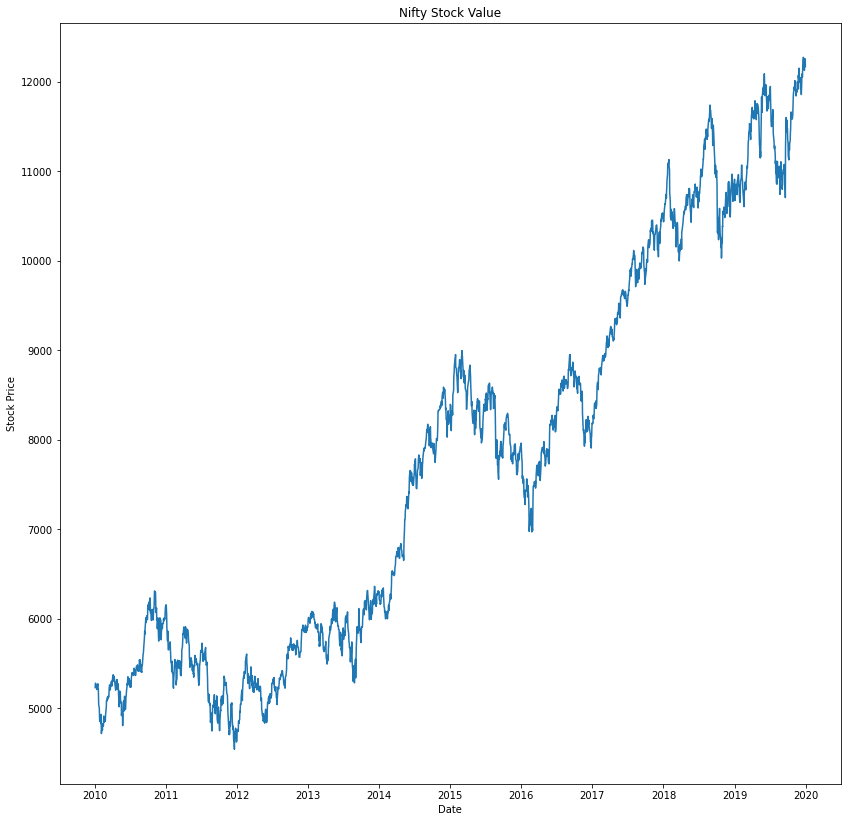

In [4]:
plt.figure(figsize=(14,14))
plt.plot(stk_data['Close'])
plt.title('Nifty Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [5]:
# cleaning up, subsettig
stk_data['Date'] = stk_data.index
nifty_df = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
nifty_df['Date'] = stk_data['Date']
nifty_df['Open'] = stk_data['Open']
nifty_df['High'] = stk_data['High']
nifty_df['Low'] = stk_data['Low']
nifty_df['Close'] = stk_data['Close']

In [6]:
# divide into train and test
# last 2 months as test
test = nifty_df[nifty_df['Date'] > pd.to_datetime('2019-1-1')]
nifty_df = nifty_df[nifty_df['Date'] <= pd.to_datetime('2019-1-1')]

C:\Users\91760\anaconda3\envs\tensorflow_gpu\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [7]:
print(test.shape)
print(nifty_df.shape)

(244, 5)
(2234, 5)


## Data Preprocessing

In [8]:
# selecting only the opening price
train_set = nifty_df.iloc[:, 1:2].values
nifty_df.iloc[:, 1:2].tail()

,Open
Date,
2018-12-26,10635.45
2018-12-27,10817.90
2018-12-28,10820.95
2018-12-31,10913.20
2019-01-01,10881.70


In [9]:
# scaling
sc = MinMaxScaler(feature_range = (-1, 1))

training_set_scaled = sc.fit_transform(train_set)


In [10]:
# preparing data labels
# X - We use the previous 50 days data to create the training set
# Y - the 61st value serves as the Y value
# So standing at any point in time we are looking back 60 days to predict the 61st value

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape(-1,1)

In [11]:
# creating test dataset

testdata = test.copy()
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((nifty_df['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_test = sc.transform(real_stock_price)

# Simple RNN


In [12]:

import tensorflow as tf
# simple RNN 

model = keras.models.Sequential([
keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics = ['RootMeanSquaredError'])

history = model.fit(x=X_train, y=y_train, batch_size=32,epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
68/68 [==============================] - 1s 8ms/step - loss: 0.9550 - root_mean_squared_error: 0.9772 - val_loss: 2.3681 - val_root_mean_squared_error: 1.5389
Epoch 2/15
68/68 [==============================] - 0s 5ms/step - loss: 0.8996 - root_mean_squared_error: 0.9485 - val_loss: 2.3642 - val_root_mean_squared_error: 1.5376
Epoch 3/15
68/68 [==============================] - 0s 6ms/step - loss: 0.8441 - root_mean_squared_error: 0.9188 - val_loss: 2.3483 - val_root_mean_squared_error: 1.5324
Epoch 4/15
68/68 [==============================] - 0s 5ms/step - loss: 0.6366 - root_mean_squared_error: 0.7979 - val_loss: 2.2743 - val_root_mean_squared_error: 1.5081
Epoch 5/15
68/68 [==============================] - 0s 5ms/step - loss: 0.3773 - root_mean_squared_error: 0.6143 - val_loss: 2.1754 - val_root_mean_squared_error: 1.4749
Epoch 6/15
68/68 [==============================] - 0s 6ms/step - loss: 0.3095 - root_mean_squared_error: 0.5563 - val_loss: 1.9533 - val_root_mean_sq

In [13]:
y_pred = sc.inverse_transform(model.predict(X_test))
mse = np.mean(keras.losses.mean_squared_error(real_stock_price, y_pred))

np.sqrt(mse)

3400.4739

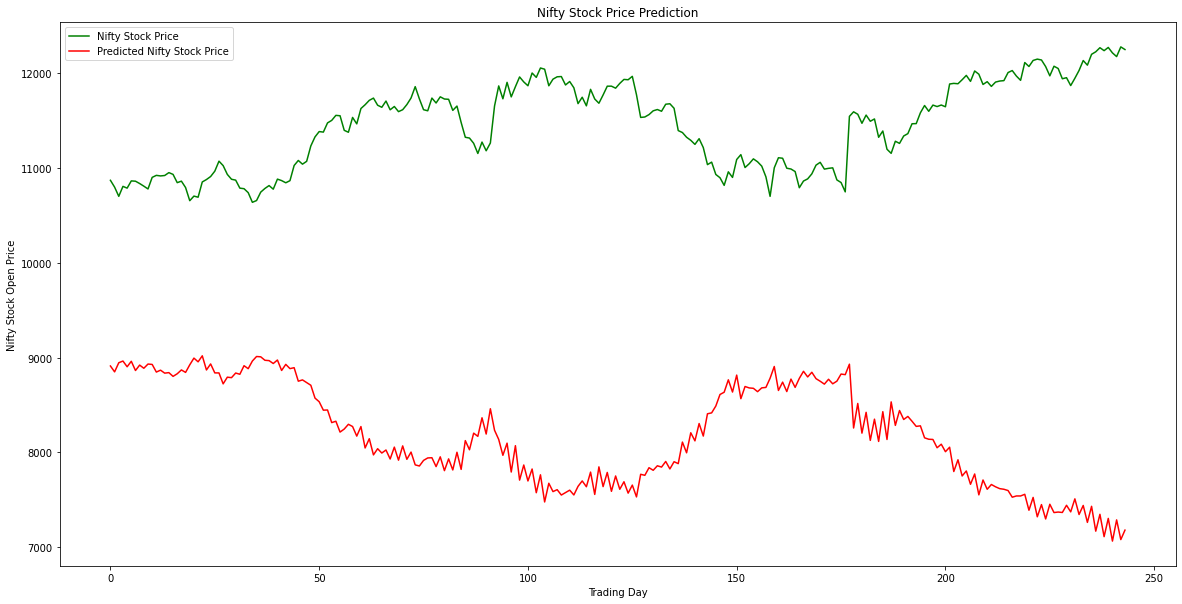

In [14]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'Nifty Stock Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Nifty Stock Price')
plt.title('Nifty Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Nifty Stock Open Price')
#plt.ylim(bottom=0)

plt.legend()
plt.show()

# Deep RNN

In [15]:
# since multiple layers, we can run for more epochs 

model = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,
1]),
keras.layers.SimpleRNN(20, return_sequences=True),
keras.layers.SimpleRNN(20, return_sequences=True),
keras.layers.SimpleRNN(1)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1e-4), metrics = ['RootMeanSquaredError'])

history = model.fit(x=X_train, y=y_train, batch_size=32,epochs=100,validation_data=(X_test, y_test))

Epoch 1/100
68/68 [==============================] - 4s 28ms/step - loss: 0.1010 - root_mean_squared_error: 0.3178 - val_loss: 0.0493 - val_root_mean_squared_error: 0.2221
Epoch 2/100
68/68 [==============================] - 1s 21ms/step - loss: 0.0279 - root_mean_squared_error: 0.1671 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2210
Epoch 3/100
68/68 [==============================] - 1s 22ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.0475 - val_root_mean_squared_error: 0.2179
Epoch 4/100
68/68 [==============================] - 2s 23ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0464 - val_root_mean_squared_error: 0.2155
Epoch 5/100
68/68 [==============================] - 2s 22ms/step - loss: 0.0135 - root_mean_squared_error: 0.1161 - val_loss: 0.0475 - val_root_mean_squared_error: 0.2180
Epoch 6/100
68/68 [==============================] - 2s 23ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_loss: 0.0457 - val_

In [16]:
y_pred = sc.inverse_transform(model.predict(X_test))
mse = np.mean(keras.losses.mean_squared_error(real_stock_price, y_pred))

np.sqrt(mse)

266.695

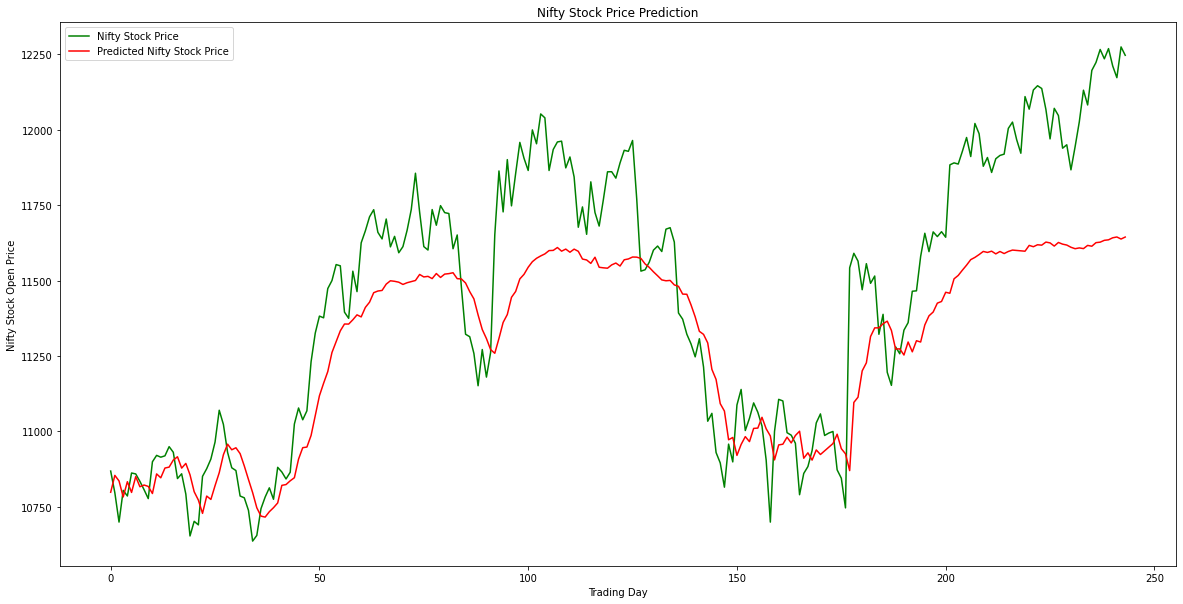

In [17]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'Nifty Stock Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Nifty Stock Price')
plt.title('Nifty Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Nifty Stock Open Price')
#plt.ylim(bottom=0)

plt.legend()
plt.show()

# LSTM Module

In [18]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
68/68 [==============================] - 11s 65ms/step - loss: 0.0282
Epoch 2/100
68/68 [==============================] - 4s 65ms/step - loss: 0.0074
Epoch 3/100
68/68 [==============================] - 4s 64ms/step - loss: 0.0076
Epoch 4/100
68/68 [==============================] - 5s 69ms/step - loss: 0.0069
Epoch 5/100
68/68 [==============================] - 5s 67ms/step - loss: 0.0065
Epoch 6/100
68/68 [==============================] - 5s 67ms/step - loss: 0.0058
Epoch 7/100
68/68 [==============================] - 4s 64ms/step - loss: 0.0064
Epoch 8/100
68/68 [==============================] - 4s 66ms/step - loss: 0.0057
Epoch 9/100
68/68 [==============================] - 5s 67ms/step - loss: 0.0054
Epoch 10/100
68/68 [==============================] - 5s 67ms/step - loss: 0.0052
Epoch 11/100
68/68 [==============================] - 4s 65ms/step - loss: 0.0058
Epoch 12/100
68/68 [==============================] - 5s 67ms/step - loss: 0.0053
Epoch 13/100
68/68 [====

In [19]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [20]:
mse = np.mean(keras.losses.mean_squared_error(real_stock_price, predicted_stock_price))

np.sqrt(mse)

301.50504

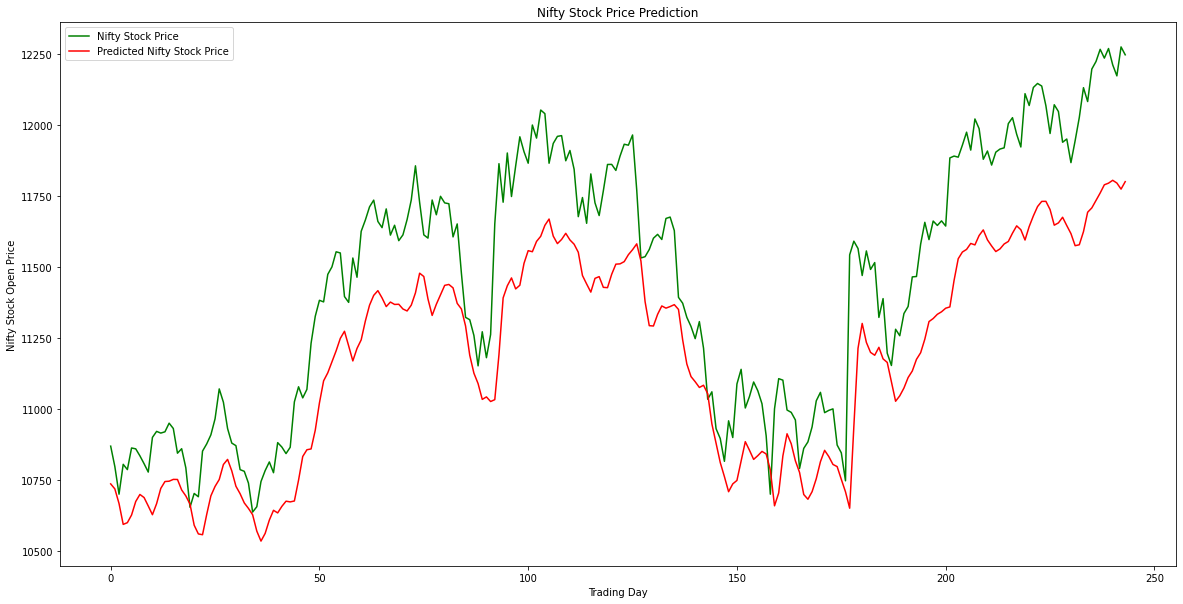

In [21]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'Nifty Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted Nifty Stock Price')
plt.title('Nifty Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Nifty Stock Open Price')
#plt.ylim(bottom=0)

plt.legend()
plt.show()